# Housekeeping

In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Gathering and Calculating RSI

In [119]:
TICKER = 'SPY'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 1000000

def get_data(ticker=TICKER):
    df = yf.download(ticker)
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]

In [120]:
def add_RSI(df, length = RSI_LENGTH):
    price_change = df['Close'].diff()

    #Separate out gains and losses
    gain = price_change.where(price_change>0,0)
    loss = -price_change.where(price_change <0, 0)

    #average gains vs losses
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    #Relative Strength - what percentage of eachother have the gains and losses been
    rs = avg_gain/avg_loss

    rsi = 100 - (100/(1+rs))

    df['RSI'] = rsi

    #Plot RSI
    plt.figure(figsize=(12, 6))
    plt.plot(df['RSI'], label='RSI')
    plt.axhline(OVERBOUGHT, color='red', linewidth=1, linestyle='--', label = 'Overbought')
    plt.axhline(OVERSOLD, color='green', linewidth=1, linestyle='--', label = 'Oversold')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df.dropna()


# Creating and Testing a Strategy

In [121]:
def add_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):
    df['Strategy'] = 0
    df['Strategy'] = np.where(df['RSI'] > overbought, 1,
                     np.where(df['RSI'] < oversold, -1, 0)) #Where the relative strength index is not overbought, it will either be a 1 or a 0, if it is overbought it will be a -1
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1
    return df

def return_summary(df, TICKER, LOOKBACK):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{TICKER} RSI Strategy Return: {strategy_return:.2f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(df['Asset_Returns'], label=f'{TICKER} Cumulative Returns', color = 'red')
    plt.plot(df['Strategy_Returns'], label = f' {TICKER} Strategy Returns', color = 'navy')
    plt.legend()
    plt.title(f'{TICKER} RSI Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    return df

# Running Code

C:\Users\EWD\AppData\Local\Temp\ipykernel_6756\4022014119.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed


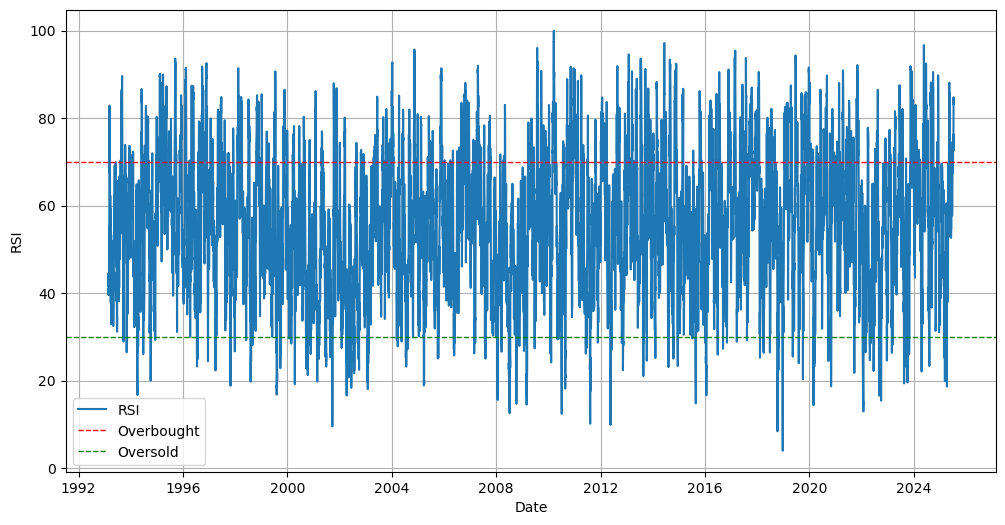

SPY Buy & Hold Return: 2489.17%
SPY RSI Strategy Return: -80.68%


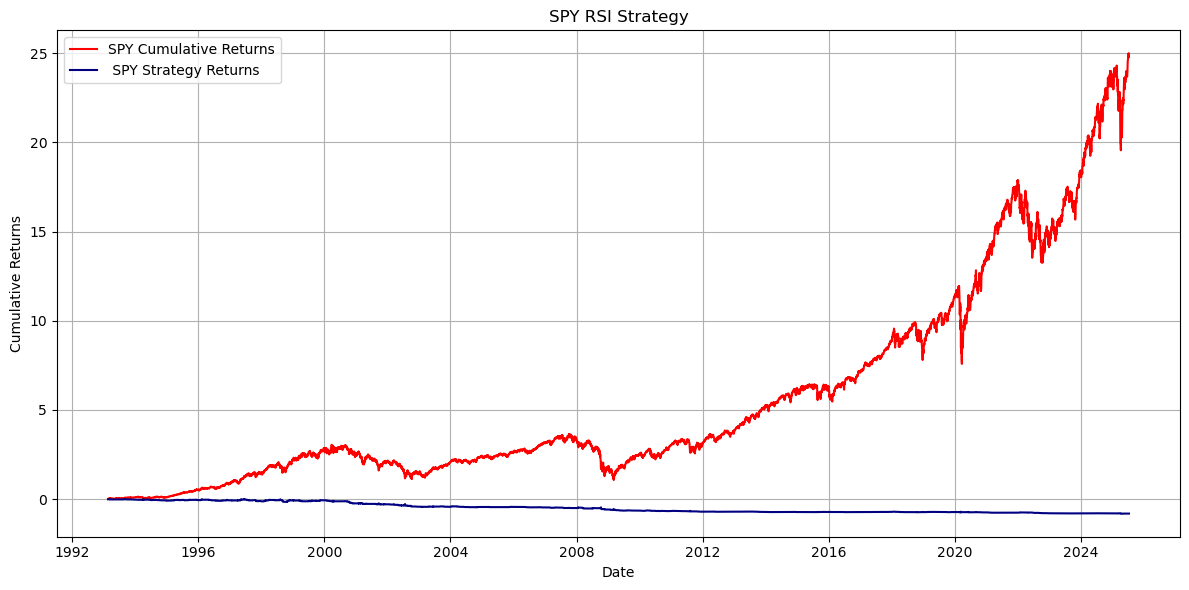

Price,Close,High,Low,Open,Volume,RSI,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,
1993-02-18,24.085665,24.380450,23.756199,24.380450,378100,41.747687,NaN,NaN,NaN
1993-02-19,24.172361,24.172361,24.050979,24.085660,34900,44.444444,0.0,0.003600,0.000000
1993-02-22,24.259056,24.293737,24.172355,24.241716,513600,41.747811,0.0,0.007199,0.000000
1993-02-23,24.241716,24.345758,24.120334,24.328418,373700,39.603595,0.0,0.006479,0.000000
1993-02-24,24.553829,24.553829,24.259045,24.259045,26300,41.345406,0.0,0.019437,0.000000
...,...,...,...,...,...,...,...,...,...
2025-07-07,620.679993,624.030029,617.869995,623.359985,74814500,76.277021,1.0,24.769685,-0.807734
2025-07-08,620.340027,622.109985,619.520020,621.349976,59024600,72.556770,1.0,24.755570,-0.807840
2025-07-09,624.059998,624.719971,620.909973,622.770020,66113300,83.947831,1.0,24.910018,-0.806687


In [124]:
def main():
    df = get_data()
    df = add_RSI(df)
    df = add_strategy(df)
    df = test_strategy(df)
    DF = return_summary(df, TICKER, LOOKBACK)
    return df

main()